In [17]:
import numpy as np
import cvxpy as cp

# Example data (replace with your actual time series data)
time_steps = 50
decision_time_series = np.zeros(time_steps)
constraint_time_series = np.random.rand(time_steps)

print(constraint_time_series)

# Parameters
forecast_horizon = 10
decision_lower_bound = 0.2
decision_upper_bound = 0.8
constraint_lower_bound = 0.0
constraint_upper_bound = 1.0

# Define the dependency function for the objective time series
def forecast_objective(decision, constraint):
    # Example dependency: objective = 2 * decision - constraint
    return 2 * decision*decision - constraint

# Define the state update function
def update_state(current_constraint, applied_decision, feedback_noise=0):
    # Example state update with feedback noise
    return current_constraint + 0.1 * applied_decision + feedback_noise


def feedback_loop(current_step, applied_decision):
    # Example external feedback: Add random noise as feedback
    noise = np.random.normal(0, 0.05)  # Mean 0, small standard deviation
    return noise

# Optimization loop for each time step
for t in range(time_steps - forecast_horizon):
    print(t, t+forecast_horizon)
    # Define variables for the decision time series over the forecast horizon
    decision_vars = cp.Variable(forecast_horizon)

    # Forecast the objective time series based on the dependency function
    forecasted_objective = forecast_objective(
        decision_vars, constraint_time_series[t:t + forecast_horizon]
    )

    # Define the objective function: maximize the sum of forecasted objective values
    objective = cp.Maximize(cp.sum(forecasted_objective))

    # Define constraints
    constraints = [
        decision_vars >= decision_lower_bound,
        decision_vars <= decision_upper_bound,
        cp.Constant(constraint_time_series[t:t + forecast_horizon]) >= constraint_lower_bound,
        cp.Constant(constraint_time_series[t:t + forecast_horizon]) <= constraint_upper_bound
    ]

    # Define the optimization problem
    problem = cp.Problem(objective, constraints)
    
    # Solve the problem and handle infeasibility
    try:
        problem.solve()
    except cp.error.SolverError as e:
        print(f"Solver error at time step {t}: {e}")
        decision_time_series[t] = decision_time_series[t - 1] if t > 0 else 0.5
        print(f"Using fallback decision: {decision_time_series[t]}\n")
        continue

    if problem.status != cp.OPTIMAL:
        print(f"Infeasible solution at time step {t}, status: {problem.status}")
        decision_time_series[t] = decision_time_series[t - 1] if t > 0 else 0.5
        print(f"Using fallback decision: {decision_time_series[t]}\n")
        continue


    # Apply only the first decision (MPC receding horizon control)
    print(decision_vars.value)
    applied_decision = decision_vars.value[0]
    decision_time_series[t] = applied_decision

    # Generate external feedback (noise) and update the state
    feedback_noise = feedback_loop(t, applied_decision)
    if t + forecast_horizon < time_steps:
        constraint_time_series[t + forecast_horizon] = update_state(
            constraint_time_series[t + forecast_horizon - 1], applied_decision, feedback_noise
        )

    # Print the results for this time step
    print(f"Time step {t}:")
    print(f"Applied decision: {applied_decision}")
    print(f"Objective value: {problem.value}")
    print(f"Feedback noise: {feedback_noise}")
    print(f"Updated constraint: {constraint_time_series[t + forecast_horizon]}\n")

[0.19662476 0.9661903  0.36941266 0.45320739 0.93737985 0.02069311
 0.74829799 0.99233698 0.98166992 0.90229066 0.09663545 0.48608476
 0.12244757 0.30044896 0.8907134  0.88866244 0.51316681 0.87906638
 0.63851473 0.54976362 0.4559519  0.19724656 0.48547108 0.45109568
 0.07289214 0.91493316 0.22737485 0.67153406 0.69320336 0.97736671
 0.46581661 0.17864912 0.98757482 0.29263297 0.04590923 0.1679762
 0.27303434 0.79521808 0.30432323 0.4101615  0.97103055 0.58228877
 0.54788995 0.76866105 0.22720531 0.7933987  0.80851142 0.4417373
 0.933726   0.08639769]
0 10


/Users/vayu/anaconda3/lib/python3.7/site-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)


DCPError: Problem does not follow DCP rules. Specifically:
The objective is not DCP. Its following subexpressions are not:
Promote(2.0, (10,)) @ var23126 @ var23126

In [14]:
import numpy as np
import cvxpy as cp

# Example data (replace with your actual time series data)
time_steps = 50
decision_time_series = np.zeros(time_steps)
constraint_time_series = np.random.rand(time_steps)
objective_time_series = np.zeros(time_steps)

# Parameters
forecast_horizon = 10
decision_lower_bound = 0.4
decision_upper_bound = 0.6
constraint_lower_bound = 0.1
constraint_upper_bound = 2.0

# Define the dependency function for the objective time series
def forecast_objective(current_objective, past_objectives, past_decisions, past_constraint):
    """
    Compute the objective as a linear function of its past values, 
    past decisions, and past constraint.
    """
    # Example: Linear combination of dependencies
    return (
        0.5 * current_objective
        + 0.3 * past_objectives[0]  # Objective at t-1
        + 0.2 * past_objectives[1]  # Objective at t-2
        + 0.3 * past_decisions[0]  # Decision at t-1
        + 0.05 * past_decisions[1]  # Decision at t-2
        + 0.1 * past_constraint    # Constraint at t-1
    )

# Define the state update function
def update_state(current_constraint, applied_decision, feedback_noise=0):
    # Example state update with feedback noise
    return current_constraint + 0.2 * applied_decision + feedback_noise

# Define the feedback loop to simulate external feedback
def feedback_loop(current_step, applied_decision):
    # Example external feedback: Add random noise as feedback
    noise = np.random.normal(0, 0.2)  # Mean 0, small standard deviation
    return noise

# Initialize past values for objectives, decisions, and constraints
past_objectives = [0.7, 0.63]  # Past two objective values
past_decisions = [0.2, 0.9]   # Past two decision values

objective_value = []
decisions = []
# Optimization loop for each time step
for t in range(2, time_steps - forecast_horizon):  # Start from t=2 to use past values
    # Define variables for the decision time series over the forecast horizon
    decision_vars = cp.Variable(forecast_horizon)

    # Forecast the current objective based on dependencies
    forecasted_objective = forecast_objective(
        objective_time_series[t - 1],  # Current objective
        past_objectives,
        past_decisions,
        constraint_time_series[t - 1],  # Past constraint value
    )

    # Define the objective function: linear function of the forecasted objective
    objective = cp.Maximize(cp.sum(forecasted_objective))

    # Define constraints
    constraints = [
        decision_vars >= decision_lower_bound,
        decision_vars <= decision_upper_bound,
        cp.Constant(constraint_time_series[t:t + forecast_horizon-5]) >= constraint_lower_bound,
        cp.Constant(constraint_time_series[t:t + forecast_horizon-5]) <= constraint_upper_bound,
    ]

    # Define the optimization problem
    problem = cp.Problem(objective, constraints)

    
    # Solve the problem and handle infeasibility
    try:
        problem.solve(verbose=False)
    except cp.error.SolverError as e:
        print(f"Solver error at time step {t}: {e}")
        decision_time_series[t] = decision_time_series[t - 1] if t > 0 else 0.5
        print(f"Using fallback decision: {decision_time_series[t]}\n")
        continue

    if problem.status != cp.OPTIMAL:
        print(f"Infeasible solution at time step {t}, status: {problem.status}")
        decision_time_series[t] = decision_time_series[t - 1] if t > 0 else 0.5
        print(f"Using fallback decision: {decision_time_series[t]}\n")
        continue
    
    #print(decision_vars.value[0:4])
    applied_decision = decision_vars.value[0]
    decision_time_series[t] = applied_decision

    # Update the past values for the next step
    past_objectives = [objective_time_series[t - 1], past_objectives[0]]
    past_decisions = [applied_decision, past_decisions[0]]

    # Generate external feedback (noise) and update the state
    feedback_noise = feedback_loop(t, applied_decision)
    if t + forecast_horizon < time_steps:
        constraint_time_series[t + forecast_horizon] = update_state(
            constraint_time_series[t + forecast_horizon - 1], applied_decision, feedback_noise
        )

    # Update the objective time series with the computed forecast
    objective_time_series[t] = forecasted_objective
    
    objective_value.append(problem.value)
    decisions.append(applied_decision)


    # Print the results for this time step
    print(f"Time step {t}:")
    print(f"Applied decision: {applied_decision}")
    print(f"Objective value: {problem.value}")
    print(f"Feedback noise: {feedback_noise}")
    print(f"Updated constraint: {constraint_time_series[t + forecast_horizon]}\n")


Time step 2:
Applied decision: 0.49999998350128316
Objective value: 0.4467429931367766
Feedback noise: 0.2735109655043602
Updated constraint: 1.0691070940882863

Time step 3:
Applied decision: 0.4999999835012876
Objective value: 0.6203242844014772
Feedback noise: 0.02494588283049567
Updated constraint: 1.1940529736190395

Time step 4:
Applied decision: 0.49999998350129715
Objective value: 0.6763080441219282
Feedback noise: -0.19571297716742633
Updated constraint: 1.0983399931518725

Time step 5:
Applied decision: 0.4999999835013319
Objective value: 0.8382572921987477
Feedback noise: -0.1352926339357093
Updated constraint: 1.0630473559164295

Time step 6:
Applied decision: 0.49999998378899746
Objective value: 0.9315109308067464
Feedback noise: 0.17511662741506473
Updated constraint: 1.338163980089294

Time step 7:
Applied decision: 0.49999998378899335
Objective value: 1.089136141242155
Feedback noise: 0.3242266263801628
Updated constraint: 1.7623906032272554

Time step 8:
Applied decisi

In [12]:
import matplotlib.pyplot as plt

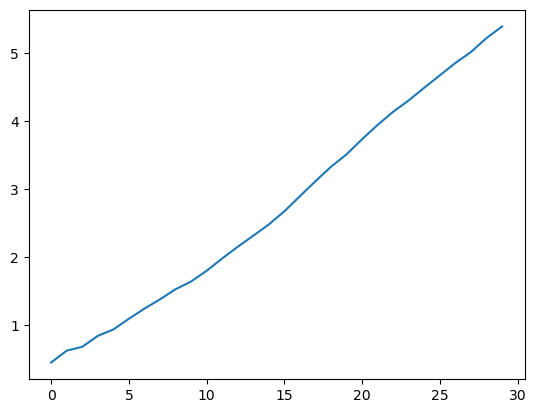

In [16]:
plt.plot(objective_value)

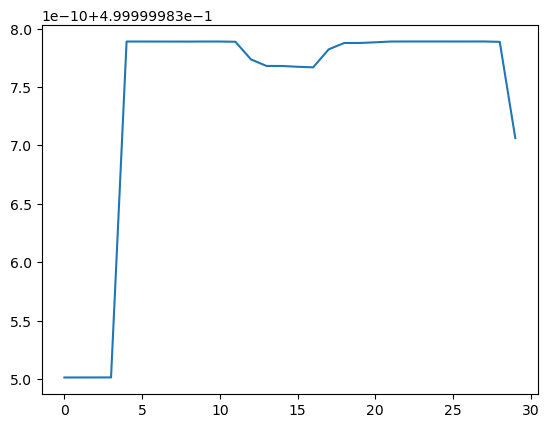

In [17]:
plt.plot(decisions)

In [18]:
print(decisions)

[0.49999998350128316, 0.4999999835012876, 0.49999998350129715, 0.4999999835013319, 0.49999998378899746, 0.49999998378899335, 0.49999998378897753, 0.4999999837889622, 0.4999999837889466, 0.49999998378900484, 0.49999998378899985, 0.4999999837887869, 0.4999999837736788, 0.49999998376807986, 0.4999999837680461, 0.499999983767376, 0.4999999837669008, 0.49999998378231886, 0.499999983787768, 0.499999983787766, 0.4999999837883345, 0.4999999837889953, 0.49999998378903304, 0.49999998378904353, 0.49999998378904115, 0.499999983789021, 0.4999999837890286, 0.49999998378903854, 0.4999999837887158, 0.4999999837062933]
